In [ ]:
! pip install xlrd

In [1]:
import pandas_profiling as pp
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

In [ ]:
! ls -l ../data/original

In [ ]:
! head ../data/original/DB_V2.TXT

## df = DB_V2.TXT

In [ ]:
# RIZIV dataset 1.8GB
# reading merge variable as a string
df = pd.read_csv("../data/original/DB_V2.TXT", sep='\t',
                 encoding='latin-1',
                 low_memory=False,
                 dtype={"reimbt_cat_id":"str", "realization_date":"str"})
df.drop_duplicates(inplace=True)
df.drop('Year', axis=1, inplace=True)
df.drop('account_yy_ss', axis=1, inplace=True)

In [ ]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V2_initial_dataset_report.html")

## pharma_ref = PHARME_REF.xlsx

In [3]:
# fixed the drug_code issue for later merging
pharma_ref = pd.read_excel("../data/original/PHARMA_REF.xlsx",
                           dtype={"drug_code":'str', "produit_pharma":'str'})
pharma_ref.drop_duplicates(inplace=True)

In [ ]:
pp.ProfileReport(pharma_ref).to_file(outputfile="../data/report/PHARMA_REF_xlsx_initial_dataset_report.html")

## reimburse_cat = reimb category.xls

In [4]:
# make sure the id's you merge on are read correctly and the same way
reimburse_cat = pd.read_excel("../data/original/reimb category.xlsx", dtype={"reimbt_cat_id":'str'})
reimburse_cat.drop_duplicates(inplace=True)
# max_pct is highly correlated with min_pct (ρ = 0.98479) and 6.1% missing values !
reimburse_cat.drop('min_pct', axis=1, inplace=True)
# remove the fresh descriptions
reimburse_cat.drop('reimbt_cat_desc_fr', axis=1, inplace=True)

In [5]:
reimburse_cat_dict = {'nd':'other', 'A':'A', 'B':'B', 'Cat 1':'other', 'Cat 2 (A)':'other', 'Cat 3':'other', 'Cat 4':'other',
       'Cat 5 (D)':'other', 'C':'C', 'Cs':'C', 'Cx':'C', 'Cxg':'C', 'D':'D', 'Csg':'C', 'Ag':'A', 'Bg':'B', 'Cg':'C',
       'Forf Ant':'other', 'Nutri Par':'other', 'Br':'other', 'Ar':'other', 'Cr':'C', 'Csr':'C', 'Cxr':'C',
       'Forf Adm':'other', 'Forf BH':'forf', 'V08':'other', 'Fa':'other', 'Fb':'other', 'Forf 1-3':'other',
       'Forf 4-':'other', 'Ri-D11':'other', 'Ri-T1':'other', 'Ri-T2':'other', 'Ri-T3':'other', 'Ri-D5':'other', 'Ri-D7':'other',
       'Ri-D2':'other', 'Ri-D9':'other', 'Ri-D6':'other', 'Ri-D10':'other', 'Ri-D3':'other', 'Ri-D1':'other', 'Ri-D8':'other',
       'Ri-T4':'other', 'Ri-D4':'other', 'Forf PET':'other', '90-A':'A', '90-B':'B', '90-Fa':'other', '90-Fb':'other',
       'Ri-T5':'other', 'Ri-T6':'other', 'Ri-T7':'other', 'Ri-T8':'other', '90-C':'C', '90-Cs':'C', '90-Cx':'C'}
reimburse_cat["reimbt_crit_long"] = reimburse_cat["reimbt_crit_long"].map(reimburse_cat_dict)

In [ ]:
pp.ProfileReport(reimburse_cat).to_file(outputfile="../data/report/reimb_category_xlsx_initial_dataset_report.html")

## MERGE left join 3x dataframes

In [6]:
df = pd.merge(df, pharma_ref, how="left", left_on="drug_code", right_on="drug_code").reset_index()

In [7]:
df = pd.merge(df, reimburse_cat, how="left", left_on="reimbt_cat_id", right_on="reimbt_cat_id").reset_index()

In [ ]:
#df.merge(pharma_ref, how="left", on="drug_code").reset_index()

In [ ]:
#df.merge(reimburse_cat, how="left", on="reimbt_cat_id").reset_index()

## Datacleaning Phase II

In [ ]:
df.columns

In [8]:
df.drop("level_0", axis=1, inplace=True)
df.drop("index", axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 46 columns):
Province                    object
Type                        object
hosp_serv_id                object
reimbt_cat_id               object
drug_code                   object
realization_date            object
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              object
type_drug_code              object
famille_produit_pharma      object
drug_name_aggregated        object
nom_produit_pharma          object
conditionnement             object
mode_administration         object
nom_firme_pharma            object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       object
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  object


In [10]:
# only keep hospitalised data, ignore ambulant data
#df = df[ (df["patient_cat"] == 'HOSP') ]

In [9]:
df = df.astype({'Type':'category', 'type_drug_code':'category', 'statut_produit_pharma':'category',
               'orphan_flag':'bool', 'chapter_IV_bis_flag':'bool', 'reimbt_cat_acute_yn':'bool',
               'reimbt_cat_chron_yn':'bool', 'reimbt_cat_psy_yn':'bool', 'reimbt_cat_fixed_rate_yn':'bool',
               'relative_care_yn':'bool', 'ami_ziv_amount_null_yn':'bool', 'not_reimbursed_null_yn':'bool', 'fee_cat':'category'})

## Our domain expert suggest to only keep these columns:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 46 columns):
Province                    object
Type                        category
hosp_serv_id                object
reimbt_cat_id               object
drug_code                   object
realization_date            object
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              object
type_drug_code              category
famille_produit_pharma      object
drug_name_aggregated        object
nom_produit_pharma          object
conditionnement             object
mode_administration         object
nom_firme_pharma            object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       category
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  o

In [10]:
# keep these columns:
# check this later !
df = df[['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated',
       'conditionnement', 'mode_administration',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat']]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 35 columns):
Province                    object
Type                        category
hosp_serv_id                object
reimbt_cat_id               object
drug_code                   object
realization_date            object
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              object
type_drug_code              category
famille_produit_pharma      object
drug_name_aggregated        object
conditionnement             object
mode_administration         object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       category
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  object
DDD                         float64
nombre_prises               

## then generate a new final report

In [15]:
#pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_merged_pharmaref_and_reimbcategory_report.html")

## output the final dataset to *.parquet format

In [16]:
#df.to_parquet("../data/dataset/DB_V4.parquet", index=False)

# UPDATE trello

## make some visualisations

In [ ]:
# show all missing values "int"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['int']).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_int.png")

In [ ]:
# show all missing values "float"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['float']).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_float.png")

In [ ]:
# show all missing values "bool"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['bool']).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_bool.png")

In [ ]:
# show all missing values "object"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['object']).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_object.png")

In [ ]:
# show all missing values "category"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['category']).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_category.png")

In [ ]:
# show all missing values "datetime"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['datetime64']).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_datetime.png")

In [ ]:
# show all zero values
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['int', 'float']) == 0, cmap='viridis', cbar=False)
plt.savefig("../data/image/zeros.png")

In [ ]:
# show all negative values
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['int', 'float']) < 0, cmap='viridis', cbar=False)
plt.savefig("../data/image/negatives.png")

In [ ]:
# show all string values "other"
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['object']) == 'other', cmap='viridis', cbar=False)
plt.savefig("../data/image/other_str.png")

In [ ]:
# show all "duplicated" values
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.duplicated(), cmap='viridis', cbar=False)
plt.savefig("../data/image/duplicated.png")

In [ ]:
# show ALL missing values
plt.close("all")
plt.figure(figsize=(14,10))
sns.heatmap(df.sample(26000).isnull(), cmap='viridis', cbar=False)
plt.savefig("../data/image/missing_all.png")

In [17]:
# show the percentage of duplicates
print (np.mean(df.duplicated()))

0.012329893116345383


In [18]:
# show the amount of duplicates
print (np.sum(df.duplicated()))

320692


In [19]:
df.shape

(26009309, 35)

In [11]:
# removing the duplicate rows
df.drop_duplicates(inplace=True)

In [21]:
df.shape

(25688617, 35)

<Figure size 1008x720 with 0 Axes>

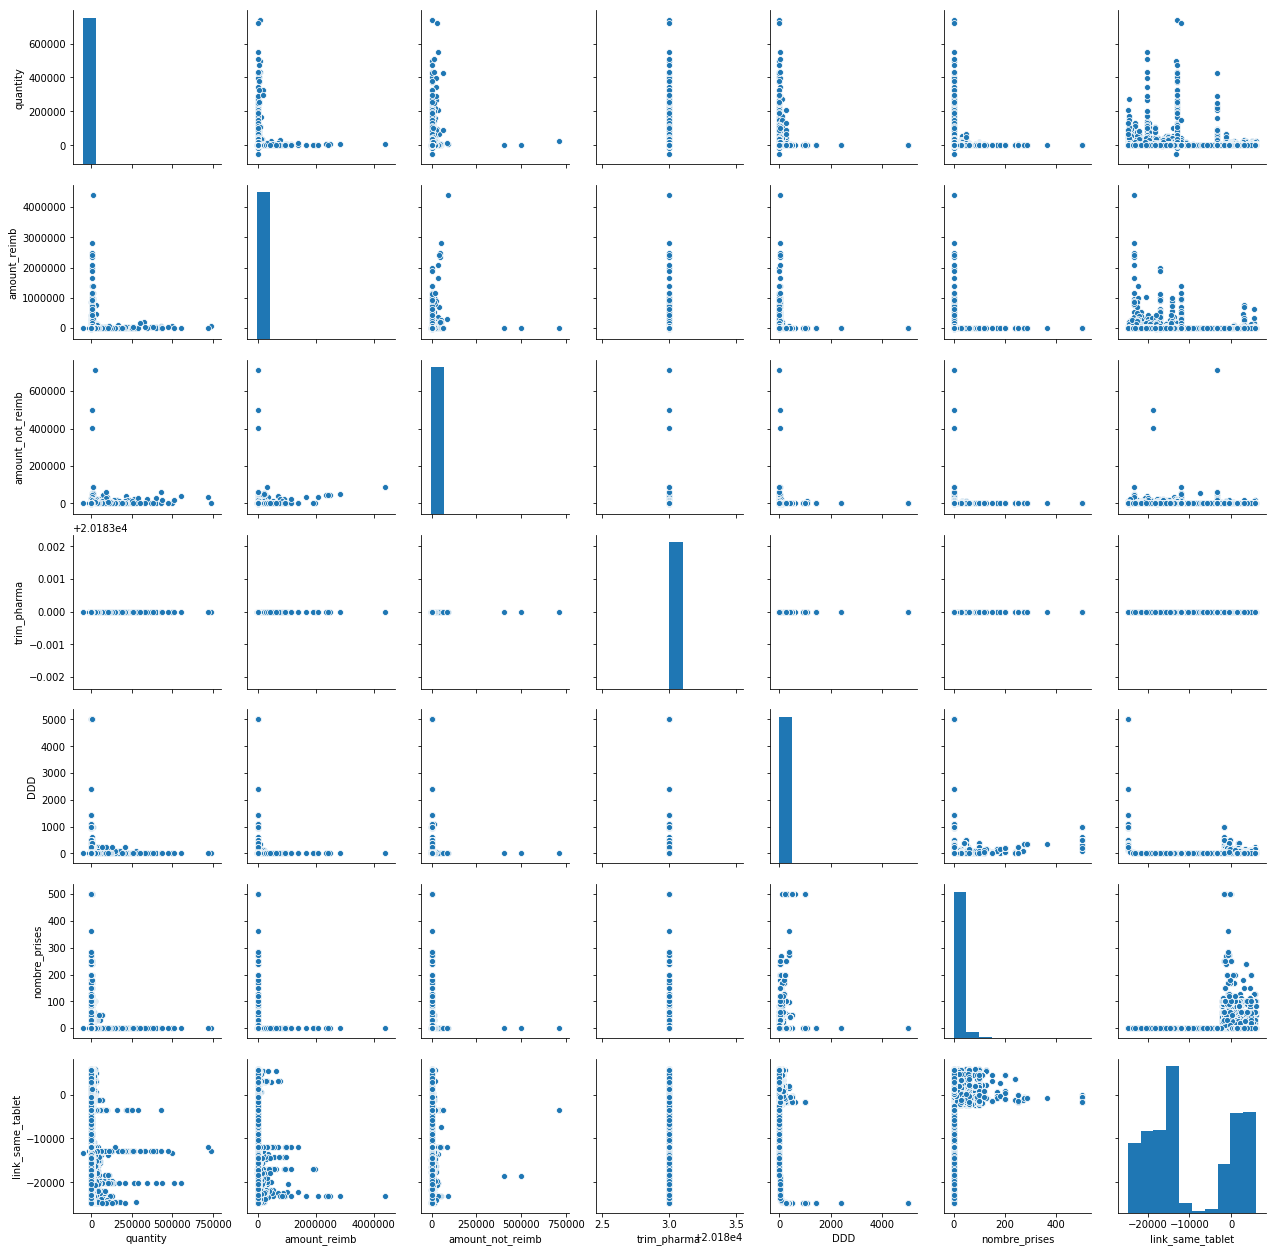

In [27]:
# show me a pairplot of all numerical combinations
plt.close("all")
plt.figure(figsize=(14,10))
sns.pairplot(df.sample(260000).select_dtypes(include=['int', 'float']))
plt.savefig("../data/image/pairplot.png")

In [ ]:
# let's calculate standardized data

In [12]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.select_dtypes(include=['int', 'float'])),
                         columns=df.select_dtypes(include=['int', 'float']).columns)

In [13]:
df_scaled.sample(5)

,quantity,amount_reimb,amount_not_reimb,trim_pharma,DDD,nombre_prises,link_same_tablet
9469296,-0.043775,-0.041005,-0.043373,0.0,-0.137499,-0.254681,-0.909850
19049146,-0.056491,-0.046152,-0.043373,0.0,-0.115639,-0.254681,-0.947743
3148481,-0.067916,-0.047735,-0.043805,0.0,-0.222751,-0.254681,-0.309666
5769288,-0.062940,-0.047608,-0.042891,0.0,-0.006341,-0.254681,-1.135206
9202530,-0.062572,-0.047608,-0.042653,0.0,-0.203077,-0.254681,-0.645701


<Figure size 1008x720 with 0 Axes>

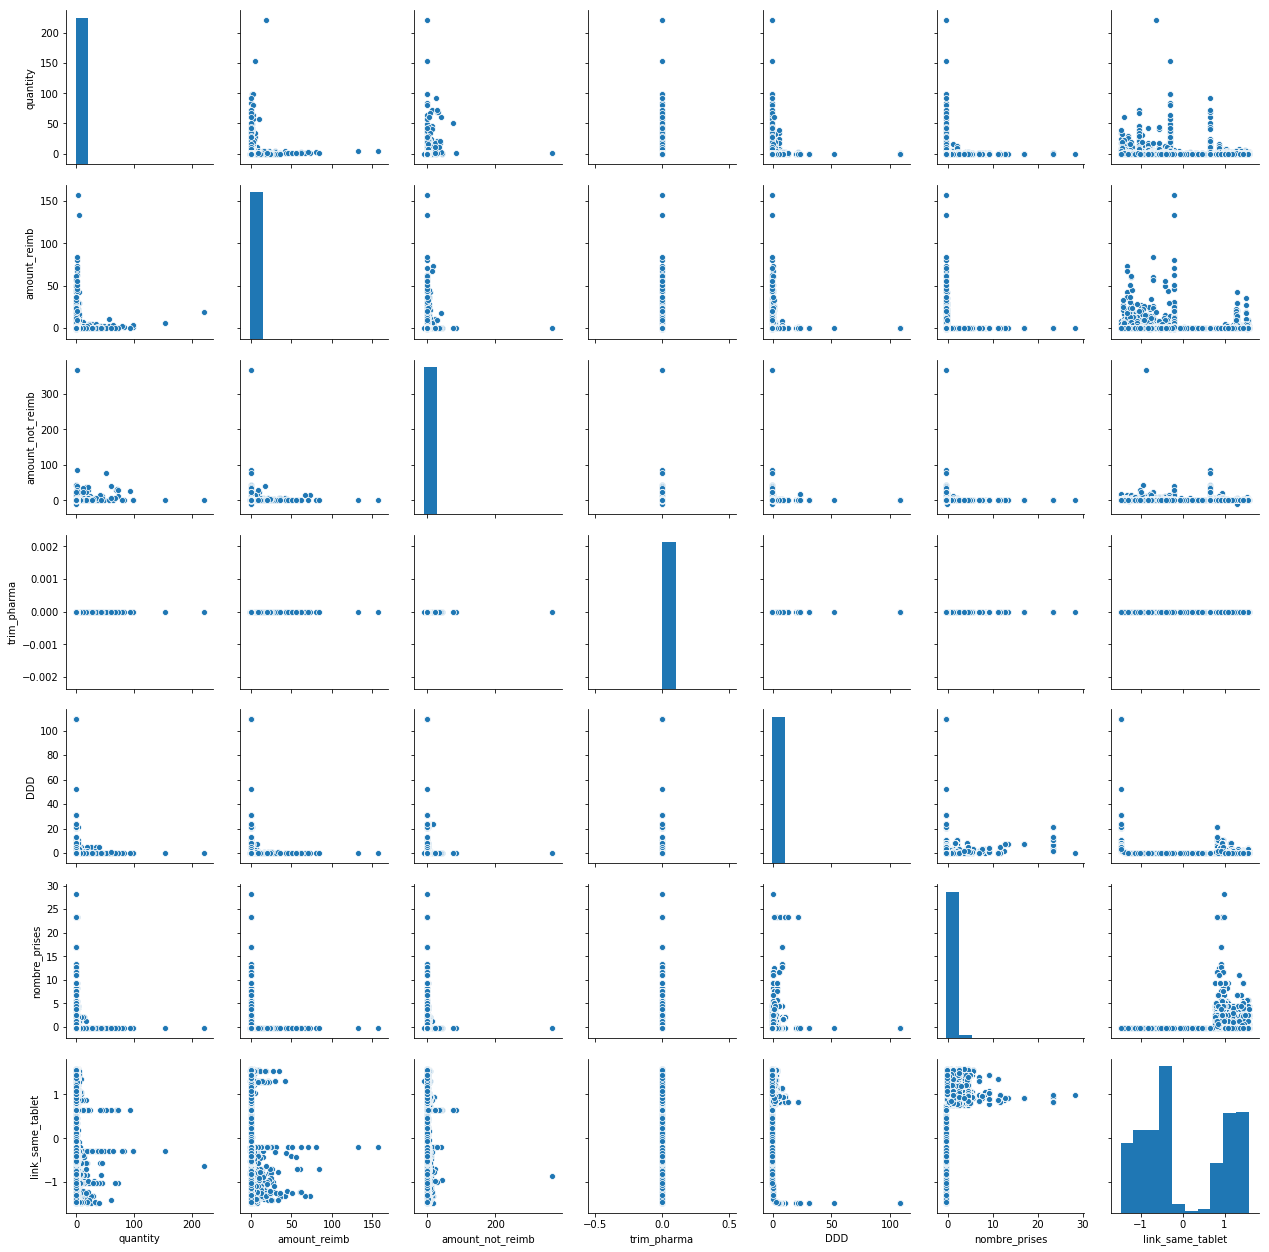

In [17]:
# show the pairplot of all numerical combinations but SCALED !
plt.close("all")
plt.figure(figsize=(14,10))
sns.pairplot(df_scaled.sample(260000))
plt.savefig("../data/image/pairplot_normalized.png")

In [ ]:
# show the pairplot of all numerical combinations but SCALED !
plt.close("all")
plt.figure(figsize=(14,10))
scaler = StandardScaler()
sns.pairplot(pd.DataFrame(scaler.fit_transform(df.select_dtypes(include=['int', 'float'])),
                         columns=df.select_dtypes(include=['int', 'float']).columns))
plt.savefig("../data/image/pairplot_normalized.png")

In [24]:
# step by step

In [25]:
plt.close("all")
plt.figure(figsize=(14,10))
scaler = StandardScaler()

<Figure size 1400x1000 with 0 Axes>

In [26]:
df_scaled = scaler.fit_transform(df.select_dtypes(include=['int', 'float']))

In [28]:
df_scaled.shape

(25688617, 7)

In [ ]:
sns.pairplot(pd.DataFrame(df_scaled,
                         columns=df.select_dtypes(include=['int', 'float']).columns))
plt.savefig("../data/image/pairplot_normalized.png")

In [22]:
df_scaled.describe()

,quantity,amount_reimb,amount_not_reimb,trim_pharma,DDD,nombre_prises,link_same_tablet
count,2.568862e+07,2.568862e+07,2.568862e+07,25688616.0,2.568862e+07,2.568862e+07,2.568862e+07
mean,-2.933601e-18,5.497446e-17,2.898750e-19,0.0,-9.182178e-17,1.224113e-17,7.852736e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.963897e+02,-1.196093e+02,-7.215508e+01,0.0,-2.249370e-01,-2.546808e-01,-1.475440e+00
25%,-6.238765e-02,-4.760786e-02,-4.337261e-02,0.0,-2.140072e-01,-2.546808e-01,-8.207673e-01
50%,-5.925485e-02,-4.749821e-02,-4.290323e-02,0.0,-2.030774e-01,-2.546808e-01,-4.053478e-01
75%,-4.469657e-02,-4.586908e-02,-3.702692e-02,0.0,-7.919890e-02,-2.073040e-01,1.069966e+00
max,1.663773e+03,2.615767e+02,2.095070e+03,0.0,1.090732e+02,4.712212e+01,1.579668e+00


In [23]:
np.var(df_scaled["quantity"])

1.0000000000000022

In [21]:
df.corr().abs().style.background_gradient()

,quantity,amount_reimb,amount_not_reimb,trim_pharma,DDD,nombre_prises,orphan_flag,chapter_IV_bis_flag,link_same_tablet,reimbt_cat_fixed_rate_yn
quantity,1,0.0465656,0.229726,nan,0.00500679,0.00195074,0.000718629,0.000292867,0.00873164,0.00345236
amount_reimb,0.0465656,1,0.0647819,nan,0.00261087,0.0118023,0.0865674,0.00349264,0.0211583,0.0236032
amount_not_reimb,0.229726,0.0647819,1,nan,0.00921589,0.00255485,0.000565664,0.000234469,0.0210087,0.0248254
trim_pharma,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
DDD,0.00500679,0.00261087,0.00921589,nan,1,0.330942,0.00916983,0.00610638,0.0859663,0.103951
nombre_prises,0.00195074,0.0118023,0.00255485,nan,0.330942,1,0.0115919,0.00673657,0.241599,0.133669
orphan_flag,0.000718629,0.0865674,0.000565664,nan,0.00916983,0.0115919,1,0.00177182,0.0281076,0.0294404
chapter_IV_bis_flag,0.000292867,0.00349264,0.000234469,nan,0.00610638,0.00673657,0.00177182,1,0.0210494,0.0199658
link_same_tablet,0.00873164,0.0211583,0.0210087,nan,0.0859663,0.241599,0.0281076,0.0210494,1,0.185214
reimbt_cat_fixed_rate_yn,0.00345236,0.0236032,0.0248254,nan,0.103951,0.133669,0.0294404,0.0199658,0.185214,1


## then generate a new final report

In [23]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_merged_pharmaref_and_reimbcategory_report.html")

## output the final dataset to *.parquet format

In [22]:
#df.to_parquet("../data/dataset/DB_V4.parquet", index=False)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
pyarrow or fastparquet is required for parquet support

## make a split for every year

In [ ]:
for i in df["realization_date"].str[:4].unique():
    print (i)

In [ ]:
for year in df["realization_date"].str[:4].unique():
    print ("selecting year: {}".format(year))
    df_year = df[ (df["realization_date"].str[:4] == year)] # here we select only that year
    print ("created dataframe")
    pp.ProfileReport(df_year).to_file(outputfile="../data/report/DB_V4_" + str(year) + "_report.html")
    print ("created html report")
    df_year.to_csv("../data/dataset/DB_V4_" + str(year) + ".csv", index=False)
    print ("created *.csv file")

## Select 2016

In [ ]:
df = df[ (df["realization_date"].str[:4] == '2016')]

In [ ]:
df.info()

## output result

In [ ]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_2016_report.html")

In [ ]:
#df.to_csv("../data/dataset/DB_V4.csv", index=False)

In [ ]:
df.info(verbose=True)

In [ ]:
#import pandas_profiling as pp

In [ ]:
#pp.ProfileReport(pharma_ref)

In [ ]:
#df["realization_date"] = df["realization_date"].astype('str')

In [ ]:
#(df["realization_date"].str[:4] == '2016').value_counts()

In [ ]:
df.columns

In [ ]:
# keep these columns:
df = df[['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated',
       'conditionnement', 'mode_administration',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat']]

In [ ]:
df["reimbt_cat_fixed_rate_yn"] = df["reimbt_cat_fixed_rate_yn"].astype('bool')

In [ ]:
df_work = df[ (df["reimbt_cat_fixed_rate_yn"] == True) ]

In [ ]:
df_work.to_csv("../data/dataset/not_reimb_workfile_2016.csv", index=False)

In [ ]:
df_work["Type"].value_counts()

In [ ]:
df_work["amount_reimb_div_quantity"] = df_work["amount_reimb"] / df_work["quantity"]

In [ ]:
#df.groupby('col1')['col2'].apply(lambda x: x)

In [ ]:
df_work = df_work[ (df_work["Type"] == "Général") ]

In [ ]:
df_work.groupby(["code_atc"])["amount_reimb_div_quantity"].sum().value_counts(ascending=False)

In [ ]:
df_work.groupby(["code_atc"]).value_counts()

In [ ]:
df_work.sample(5).T

In [ ]:
df_work.statut_produit_pharma.unique()

In [ ]:
statut_produit_pharma_dict = {'G':True, 'orig':False, 'orig R':True}

In [ ]:
df_work["B_IsGeneric"] = df_work["statut_produit_pharma"].map(statut_produit_pharma_dict)

In [ ]:
df_work["B_IsGeneric"].value_counts(normalize=True)

In [ ]:
generic = df_work.groupby(["code_atc_1"])["B_IsGeneric"].value_counts(normalize=True)
generic

In [ ]:
generic.index

In [ ]:
newgeneric = pd.DataFrame()

In [ ]:
newgeneric["percentageOfGeneric"] = generic.values

In [ ]:
newgeneric["ATC"] = pd.Series(['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V', 'X', 'Z'])

In [ ]:
newgeneric

In [ ]:
import seaborn as sns

In [ ]:
generic.plot(kind="bar")

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data=newgeneric, x="percentageOfGeneric", y="ATC", color='blue' )

In [ ]:
genericByService = df_work.groupby(["hosp_serv_id"])["B_IsGeneric"].value_counts(normalize=True)
genericByService

In [ ]:
genericByService.index

In [ ]:
newgenericByService = pd.DataFrame()

In [ ]:
newgenericByService["percentageOfGeneric"] = genericByService.values

In [ ]:
newgenericByService["Service"] = pd.Series([2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990, 2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990])

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data=newgenericByService, y="percentageOfGeneric", x="Service", color='blue' )

In [ ]:
df.info()

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()